<a href="https://colab.research.google.com/github/EstebanPiacentino/GAN4DataAnonymization/blob/master/GAN_with_PyTorch_Tyroid_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)


Mounted at /gdrive


In [0]:
cd /gdrive/My Drive/Colab Notebooks

/gdrive/My Drive/Colab Notebooks


In [0]:
#Dependencies
import numpy as np
import pandas as pd
import os
from skimage import io, transform
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from random import choice

from zipfile import ZipFile
import io as ios

In [0]:
#dataFile=pd.read_csv('tyroid_clean.csv')
#binaryVars=['Sex','On_thyroxine','Query_on_thyroxine','On_antithyroid_medication','Sick','Pregnant','Thyroid_surgery','I131_treatment','Query_hypothyroid','Query_hyperthyroid','Lithium','Goitre','Tumor','Hypopituitary','Psych']
#continuousVars=['Age','TSH','T3','TT4','T4U','FTI']
#
#row=12
#
#print(len(dataFile))
#
#cont_data_sample=dataFile.loc[row,continuousVars].values
#binary_data_sample=dataFile.loc[row,binaryVars].values
#
#cont_data_sample_bloc=np.reshape(cont_data_sample,(2,3)) #With .T we can transpose it
#binary_data_sample_bloc=np.reshape(binary_data_sample,(5,3))
#
#print(cont_data_sample)
#print(binary_data_sample)
#
#sample_bloc=np.concatenate((cont_data_sample_bloc,binary_data_sample_bloc))
#extra_bloc=np.zeros((7,4))
#
#sample_bloc=np.concatenate((sample_bloc,extra_bloc), axis=1)
#
#plt.axis('off')
#plt.grid(b=None)
#
#im=plt.imshow(sample_bloc)

#Inverse transformation
#print(np.reshape(sample_bloc[:2,:3],(6)))
#print(np.reshape(sample_bloc[2:,:3],(15)))



In [0]:
class TyroidDataset(Dataset):
    """Fingerprints dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.archive = pd.read_csv(self.root_dir)
        self.binaryVars=['Sex','On_thyroxine','Query_on_thyroxine','On_antithyroid_medication','Sick','Pregnant','Thyroid_surgery','I131_treatment','Query_hypothyroid','Query_hyperthyroid','Lithium','Goitre','Tumor','Hypopituitary','Psych']
        self.continuousVars=['Age','TSH','T3','TT4','T4U','FTI']

    def __len__(self):
        return 6330 #Total number of images

    def __getitem__(self, idx):
        cont_data_sample=self.archive.loc[idx,self.continuousVars].values
        binary_data_sample=self.archive.loc[idx,self.binaryVars].values
        
        cont_data_sample_bloc=np.reshape(cont_data_sample,(2,3)) #With .T we can transpose it
        binary_data_sample_bloc=np.reshape(binary_data_sample,(5,3))
        
        sample_bloc=np.concatenate((cont_data_sample_bloc,binary_data_sample_bloc))
        extra_bloc=np.zeros((7,4))
        
        sample_bloc=np.uint8(np.concatenate((sample_bloc,extra_bloc), axis=1))
        
        image = sample_bloc #io.imread(sample_bloc)

        if self.transform:
            image = self.transform(image)

        return image

In [0]:
#Load
out_dir = './Fingerprints_dataset' #saves dataset here
transform =  transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))])
#download MNIST, save and apply transform 
tyroid_data =  TyroidDataset(root_dir='tyroid_clean.csv', transform=transform)
#Data loader feeds data as inputs and labels, of fixed batch size
train_loader = torch.utils.data.DataLoader(tyroid_data, batch_size = 20, shuffle = True)

In [0]:
#Get Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
#Define discriminator
def disc_model():
    discriminator_model = nn.Sequential(
      nn.Linear(7 *7, 64),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(64, 1),
      nn.Sigmoid()
      ).to(device)
    return discriminator_model
#create a discriminator network
discriminator = disc_model()
#if we want to start from a checkpoint model
#discriminator.load_state_dict(torch.load('DataOutput/f_name_RawData.pth')['dis_state_dict'])
#discriminator.eval()

In [0]:
#Define generator
def gen_model():
    generator_model = nn.Sequential(
          nn.Linear(5, 64),
          nn.LeakyReLU(0.2),
          nn.Linear(64 , 7*7),
          nn.Tanh()    
          ).to(device)
    return generator_model
#create a generator network
generator = gen_model()
#if we want to start from a checkpoint model
#generator.load_state_dict(torch.load('DataOutput/f_name_RawData.pth')['gen_state_dict'])
#generator.eval()

In [0]:
#Noise generator
from torch.autograd import Variable
def rand_vecs(batch_size):
    return Variable(torch.randn(batch_size, 5)).to(device)

In [0]:
#Define optimizer and loss criterion
import torch.optim as optim
#create separate optimizers, use BCELoss for both networks
d_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr = 0.0002)
criterion = nn.BCELoss()

In [0]:
#Get the labels
def ones_or_zeros(batch_size, labels):
    if labels == 1:
        return Variable(torch.ones(batch_size, 1)).to(device)
    elif labels == 0:
        return Variable(torch.zeros(batch_size, 1)).to(device)

torch.Size([1, 7, 7])


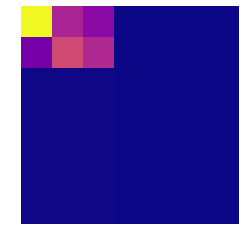

In [0]:
#Check ground truth sample:
for inputs in train_loader:
  print(inputs[0].shape)
  sample=inputs[0].view(-1, 7).detach().numpy()
  plt.axis('off')
  plt.grid(b=None)
  im=plt.imshow(sample)
  im.set_cmap('plasma')
  break

 100.0% Epoch passedloss_disc:1.14144.., loss_generator: 0.60333


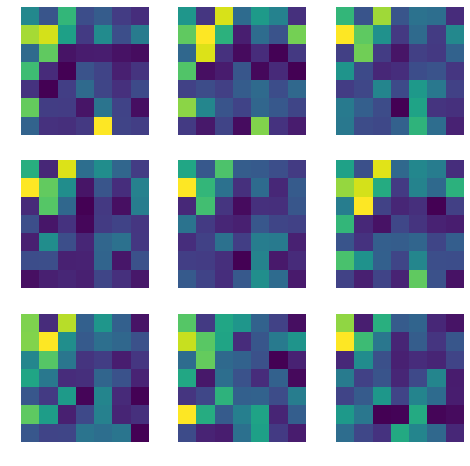

 100.0% Epoch passedNew epoch: 2
 100.0% Epoch passedNew epoch: 3
 100.0% Epoch passedNew epoch: 4
 100.0% Epoch passedNew epoch: 5
 100.0% Epoch passedloss_disc:1.41267.., loss_generator: 0.6488


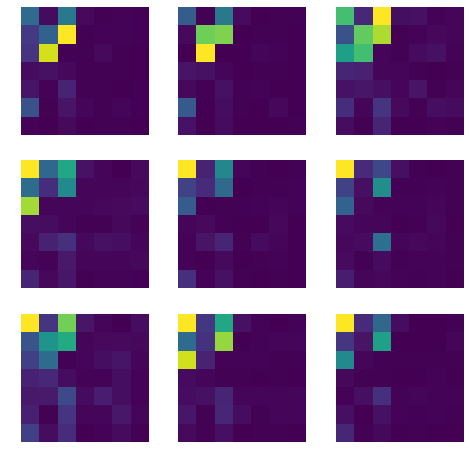

 100.0% Epoch passedNew epoch: 7
 100.0% Epoch passedNew epoch: 8
 100.0% Epoch passedNew epoch: 9
 100.0% Epoch passedNew epoch: 10
 100.0% Epoch passedloss_disc:1.46759.., loss_generator: 0.68892


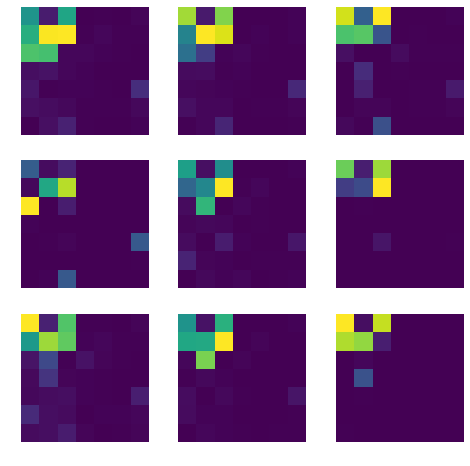

 100.0% Epoch passedNew epoch: 12
 100.0% Epoch passedNew epoch: 13
 100.0% Epoch passedNew epoch: 14
 100.0% Epoch passedNew epoch: 15
 100.0% Epoch passedloss_disc:1.46044.., loss_generator: 0.74674


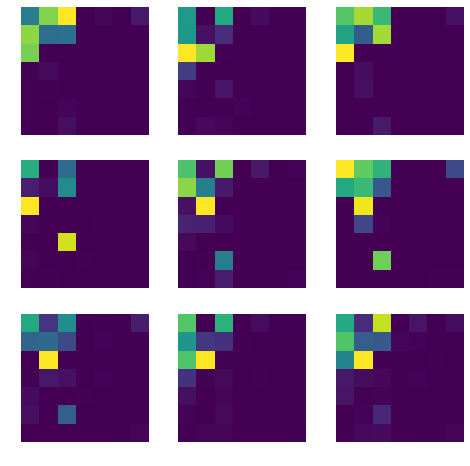

 100.0% Epoch passedNew epoch: 17
 100.0% Epoch passedNew epoch: 18
 100.0% Epoch passedNew epoch: 19
 100.0% Epoch passedNew epoch: 20
 100.0% Epoch passedloss_disc:1.26822.., loss_generator: 0.76719


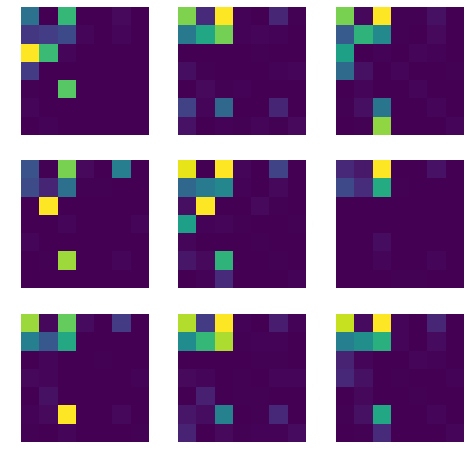

 100.0% Epoch passedNew epoch: 22
 100.0% Epoch passedNew epoch: 23
 100.0% Epoch passedNew epoch: 24
 100.0% Epoch passedNew epoch: 25
 100.0% Epoch passedloss_disc:1.44572.., loss_generator: 0.73573


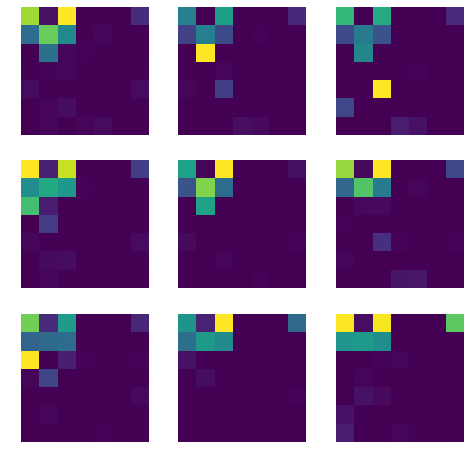

 100.0% Epoch passedNew epoch: 27
 100.0% Epoch passedNew epoch: 28
 100.0% Epoch passedNew epoch: 29
 100.0% Epoch passedNew epoch: 30
 100.0% Epoch passedloss_disc:1.34311.., loss_generator: 0.70643


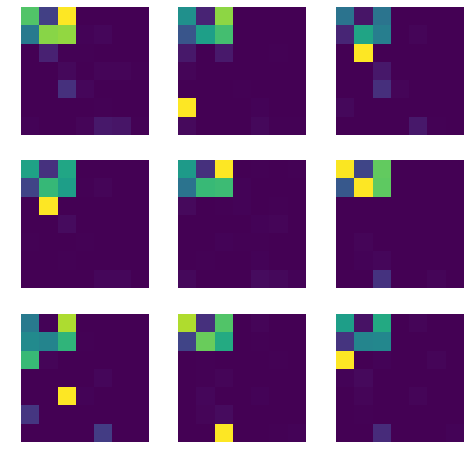

 100.0% Epoch passedNew epoch: 32
 100.0% Epoch passedNew epoch: 33
 100.0% Epoch passedNew epoch: 34
 100.0% Epoch passedNew epoch: 35
 100.0% Epoch passedloss_disc:1.35084.., loss_generator: 0.78409


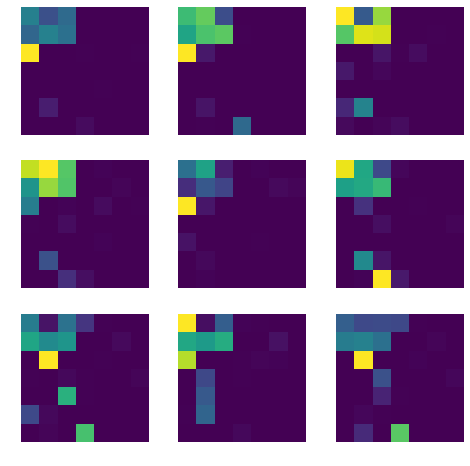

 100.0% Epoch passedNew epoch: 37
 100.0% Epoch passedNew epoch: 38
 100.0% Epoch passedNew epoch: 39
 100.0% Epoch passedNew epoch: 40
 100.0% Epoch passedloss_disc:1.30785.., loss_generator: 0.7319


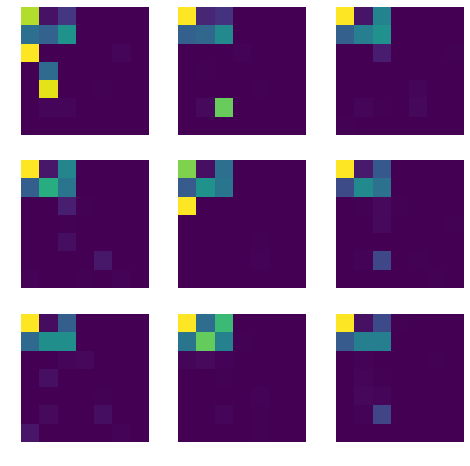

 100.0% Epoch passedNew epoch: 42
 100.0% Epoch passedNew epoch: 43
 100.0% Epoch passedNew epoch: 44
 100.0% Epoch passedNew epoch: 45
 100.0% Epoch passedloss_disc:1.30837.., loss_generator: 0.72978


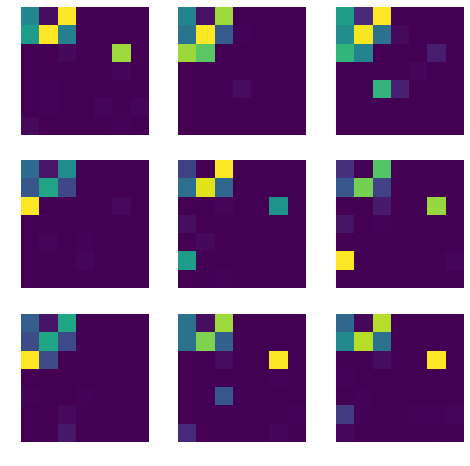

 100.0% Epoch passedNew epoch: 47
 100.0% Epoch passedNew epoch: 48
 100.0% Epoch passedNew epoch: 49
 100.0% Epoch passedNew epoch: 50
 100.0% Epoch passedloss_disc:1.36316.., loss_generator: 0.8021


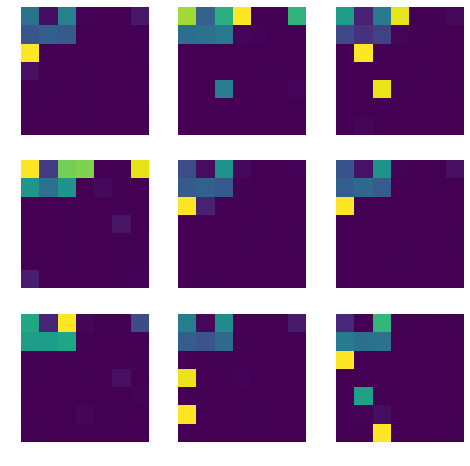

 100.0% Epoch passedNew epoch: 52
 100.0% Epoch passedNew epoch: 53
 100.0% Epoch passedNew epoch: 54
 100.0% Epoch passedNew epoch: 55
 100.0% Epoch passedloss_disc:1.34639.., loss_generator: 0.78238


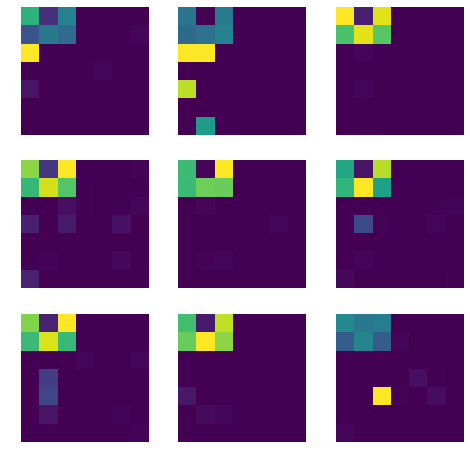

 100.0% Epoch passedNew epoch: 57
 100.0% Epoch passedNew epoch: 58
 100.0% Epoch passedNew epoch: 59
 100.0% Epoch passedNew epoch: 60
 100.0% Epoch passedloss_disc:1.36269.., loss_generator: 0.71301


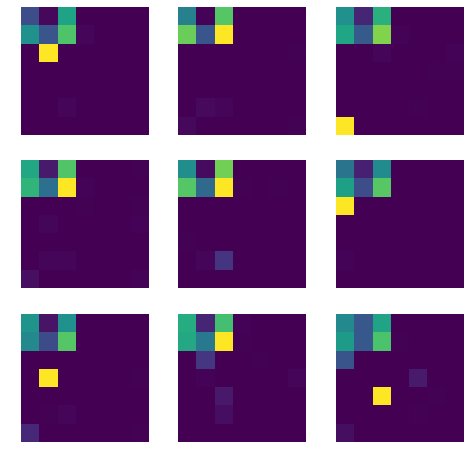

 100.0% Epoch passedNew epoch: 62
 100.0% Epoch passedNew epoch: 63
 100.0% Epoch passedNew epoch: 64
 100.0% Epoch passedNew epoch: 65
 100.0% Epoch passedloss_disc:1.51663.., loss_generator: 0.71426


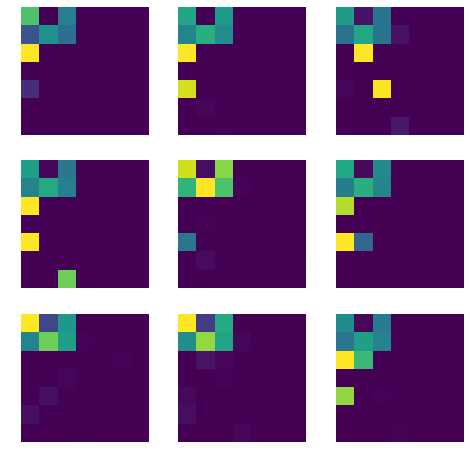

 100.0% Epoch passedNew epoch: 67
 100.0% Epoch passedNew epoch: 68
 100.0% Epoch passedNew epoch: 69
 100.0% Epoch passedNew epoch: 70
 100.0% Epoch passedloss_disc:1.47475.., loss_generator: 0.82242


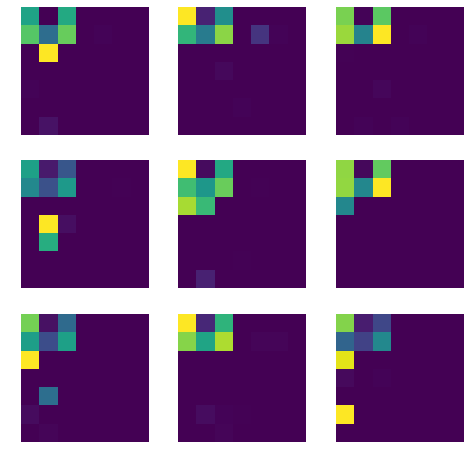

 100.0% Epoch passedNew epoch: 72
 100.0% Epoch passedNew epoch: 73
 100.0% Epoch passedNew epoch: 74
 100.0% Epoch passedNew epoch: 75
 100.0% Epoch passedloss_disc:1.3688.., loss_generator: 0.73479


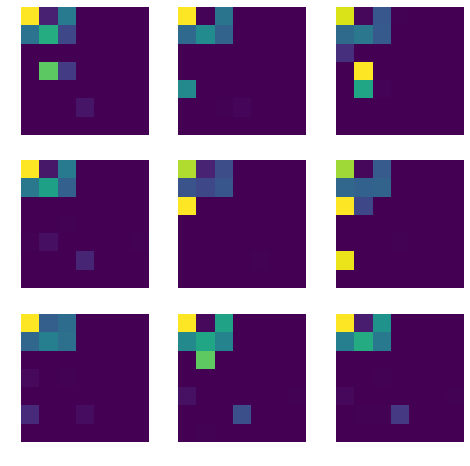

 100.0% Epoch passedNew epoch: 77
 100.0% Epoch passedNew epoch: 78
 100.0% Epoch passedNew epoch: 79
 100.0% Epoch passedNew epoch: 80
 100.0% Epoch passedloss_disc:1.51765.., loss_generator: 0.78265


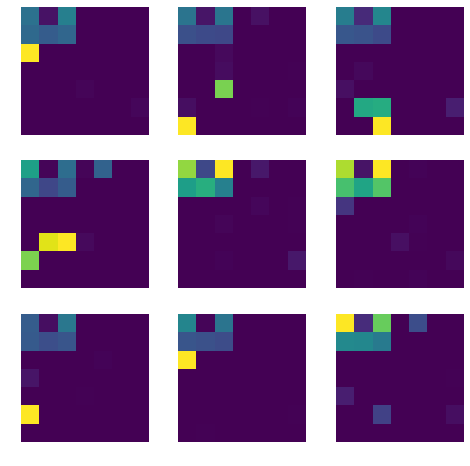

 100.0% Epoch passedNew epoch: 82
 100.0% Epoch passedNew epoch: 83
 100.0% Epoch passedNew epoch: 84
 100.0% Epoch passedNew epoch: 85
 100.0% Epoch passedloss_disc:1.49087.., loss_generator: 0.73145


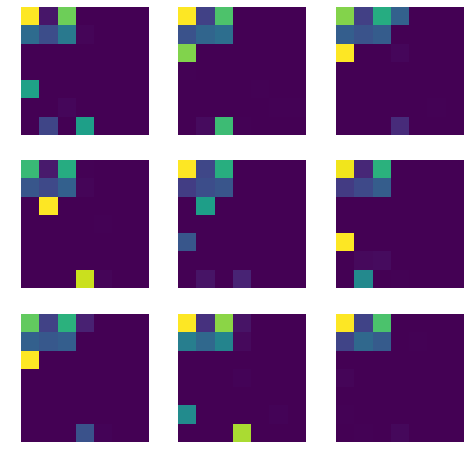

 100.0% Epoch passedNew epoch: 87
 100.0% Epoch passedNew epoch: 88
 100.0% Epoch passedNew epoch: 89
 100.0% Epoch passedNew epoch: 90
 100.0% Epoch passedloss_disc:1.44365.., loss_generator: 0.59934


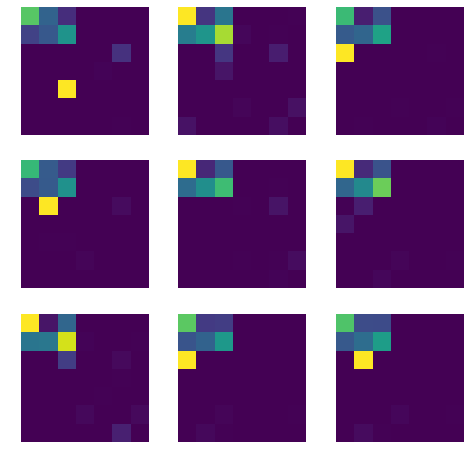

 100.0% Epoch passedNew epoch: 92
 100.0% Epoch passedNew epoch: 93
 100.0% Epoch passedNew epoch: 94
 100.0% Epoch passedNew epoch: 95
 100.0% Epoch passedloss_disc:1.54411.., loss_generator: 0.70685


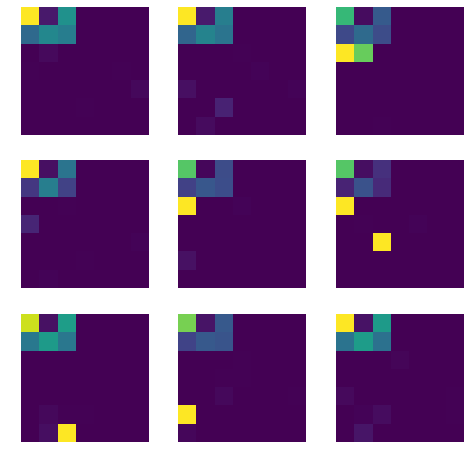

 100.0% Epoch passedNew epoch: 97
 100.0% Epoch passedNew epoch: 98
 100.0% Epoch passedNew epoch: 99
 100.0% Epoch passedNew epoch: 100
 100.0% Epoch passedloss_disc:1.49645.., loss_generator: 0.68672


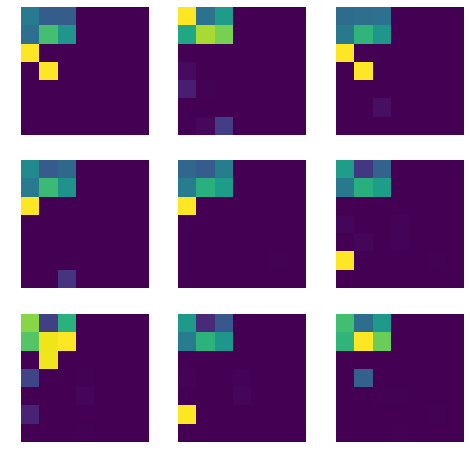

In [0]:
#TRAIN
#Create empty lists to catch losses
losses_disc, losses_generator = [], []
print_freq = 5 #fix how frequently to print losses
for epoch in range(101): #100 by default
    #Networks are training hence, .train()
    discriminator.train()
    generator.train()
    
#Train discriminator
    tot_inputs_passed=0
    for inputs in train_loader:
        
        #.to(device)--> work in either cpu or gpu     
        inputs = inputs.to(device) 
        
        batch_size = inputs.size(0)
        #Note: inputs.shape ->([52, 1, 28, 28])        
        #reshape to (batch_size, features) as expected by network
        real_data = inputs.view(inputs.size(0), -1) 
        
        #Flush the retained gradients
        d_optimizer.zero_grad()
        # probabilities given real data       
        pred_real = discriminator(real_data) 
        
        #Computing loss for real data         
        loss_real=criterion(pred_real, ones_or_zeros(batch_size, 1))
        
        #Note grads for gen are detached
        fake_data = generator(rand_vecs(batch_size)).detach()
 
        fake_data = fake_data.to(device)
        # probabilities given fake data
        pred_fake = discriminator(fake_data) 
        
        #Computing loss for generated data
        loss_fake=criterion(pred_fake, ones_or_zeros(batch_size, 0))
        
        loss_disc = loss_real + loss_fake  #combined loss
        losses_disc.append(loss_disc.item()) # log the losses
        #computes the gradients        
        loss_disc.backward()
        #update parameters using gradients & optimizer rules       
        d_optimizer.step()
 
        #discriminator completes a loop
#Train generator
        #Trains from scratch, newly generated data are used
        g_optimizer.zero_grad()
        #generates image/feature vector
        fake_data_new = generator(rand_vecs(batch_size))  
               
        fake_data_new = fake_data_new.to(device)
        
        pred_fake_new = discriminator(fake_data_new)
        #Generator's loss minimized after, labels are set to 1 
        loss_generator = criterion(pred_fake_new,   ones_or_zeros(batch_size, 1))
 
        losses_generator.append(loss_generator.item())
        loss_generator.backward()
        
        g_optimizer.step() #completes training loop for generator
        
        #Printing the Evolution:
        #image=generator(rand_vecs(batch_size))[0]
        #image_host=image.cpu()
        #sample=image_host.view(-1, 275).detach().numpy()
        #plt.axis('off')
        #plt.grid(b=None)
        #plt.imshow(sample)
        #plt.show()
            
        tot_inputs_passed+=1       
        
        print('\r',str(round(float(tot_inputs_passed)/len(train_loader)*100,2))+"% Epoch passed",end='')
        
#Print and save epoch, generator_state_dict as chk_point
    if epoch % print_freq ==0:
        print("loss_disc:{:.6}.., loss_generator: {:.5}".format(loss_disc, loss_generator))
        torch.save({
            'epoch': epoch,
            'gen_state_dict': generator.state_dict(),
            'dis_state_dict': discriminator.state_dict(),
            }, ('DataOutput/f_name_RawData' + '.pth'))
        torch.save({
            'epoch': epoch,
            'losses': "loss_disc:{:.6}.., loss_generator: {:.5}".format(loss_disc, loss_generator),
            }, ('DataOutput/f_name_' + str(epoch) + '.txt'))
        fig=plt.figure(figsize=(8, 8))
        columns = 3
        rows = 3
        for i in range(1, columns*rows +1):
            image=generator(rand_vecs(batch_size))[choice(range(batch_size))]
            image_host=image.cpu()
            sample=image_host.view(-1, 7).detach().numpy()
            #can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
            fig.add_subplot(rows, columns, i)
            plt.axis('off')
            plt.grid(b=None)
            plt.imshow(sample)
            plt.imsave('DataOutput/Epoch_'+str(epoch)+'_sample_'+str(i)+'.png', sample)
        plt.show()
    else:
        print("New epoch: "+str(epoch+1))

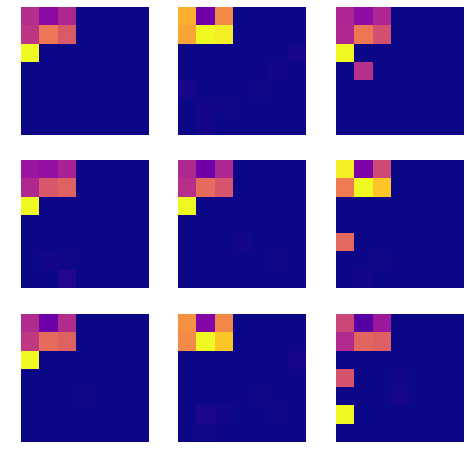

In [0]:
#Loading Images

generator=gen_model()
generator.load_state_dict(torch.load('DataOutput/f_name_RawData.pth')['gen_state_dict'])
generator.eval()

fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    image=generator(rand_vecs(20))[choice(range(20))]
    image_host=image.cpu()
    sample=image_host.view(-1, 7).detach().numpy()
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.grid(b=None)
    im=plt.imshow(sample)
    im.set_cmap('plasma')
    plt.imsave('Final_Result_'+str(i)+'.png', sample, cmap='plasma')
plt.show()

In [0]:
def remap(x):
  A=-1
  B=1
  C=1
  D=255
  
  out=(x-A)/(B-A)*(D-C)+C
  return int(out)

def remap_bin(x):
  A=-1
  B=1
  C=1
  D=255
  
  out=(x-A)/(B-A)*(D-C)+C
  
  if out<=255/2:
    out=1
  else:
    out=255
  return int(out)

output_dataframe=pd.DataFrame(columns=['Age','Sex','On_thyroxine','Query_on_thyroxine','On_antithyroid_medication','Sick','Pregnant','Thyroid_surgery','I131_treatment','Query_hypothyroid','Query_hyperthyroid','Lithium','Goitre','Tumor','Hypopituitary','Psych','TSH','T3','TT4','T4U','FTI'])
binaryVars=['Sex','On_thyroxine','Query_on_thyroxine','On_antithyroid_medication','Sick','Pregnant','Thyroid_surgery','I131_treatment','Query_hypothyroid','Query_hyperthyroid','Lithium','Goitre','Tumor','Hypopituitary','Psych']
continuousVars=['Age','TSH','T3','TT4','T4U','FTI']

generator=gen_model()
generator.load_state_dict(torch.load('DataOutput/f_name_RawData.pth')['gen_state_dict'])
generator.eval()

fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3

row=-1
for i in range(int(6330/20)):
  for j in range(20): 
    row+=1
    image=generator(rand_vecs(20))[j]
    image_host=image.cpu()
    sample=image_host.view(-1, 7).detach().numpy()
    
    #plt.imshow(sample)
    
    cont_data_sample=[remap(x) for x in np.reshape(sample[:2,:3],(6))]
    binary_data_sample=[remap_bin(x) for x in np.reshape(sample[2:,:3],(15))]
    
    #print(cont_data_sample)
    #print(binary_data_sample)
    
    output_dataframe.loc[row,continuousVars]=cont_data_sample
    output_dataframe.loc[row,binaryVars]=binary_data_sample
    
    print('\r',str(row)+" rows processed",end='')

output_dataframe.to_csv('output_tyroids_data.csv')

 6319 rows processed

<Figure size 576x576 with 0 Axes>